Conditional Worflow in Langgraph
===============================================


In [100]:
# customer support workflow in Langgraph..
from langgraph.graph import StateGraph,START,END
from langchain_openai import ChatOpenAI
from typing import TypedDict, Literal, Optional, Dict, Any
from pydantic import BaseModel, Field
from dotenv import load_dotenv
import os

In [101]:
load_dotenv()
HF_TOKEN = os.getenv("HF_KEY")
llm = ChatOpenAI(
    model="deepseek-ai/DeepSeek-V3-0324",
    api_key = HF_TOKEN,
    base_url="https://router.huggingface.co/v1",
    temperature=0,
    max_tokens = 500,
)

In [102]:
llm.invoke("hey there").content

"Hey! 😊 How's it going? What's on your mind today?"

In [103]:
# Define the state structure
class SentimentSchema(BaseModel):

    sentiment: Literal['positive', 'neutral', 'negative'] = Field(..., description="The sentiment of the customer message")

class DiagnosisSchema(BaseModel):
    issue_type: Literal['Bug', 'UX', 'Performance', 'Other'] = Field(..., description="The type of issue reported by the customer")
    urgency: Literal['Low', 'Medium', 'High'] = Field(..., description="The urgency level of the issue")
    tone: Literal['angry', 'frustrated', 'confused', 'satisfied', 'neutral'] = Field(..., description="The tone of the customer message")


In [104]:
structure_llm = llm.with_structured_output(SentimentSchema)
structure_llm_2 = llm.with_structured_output(DiagnosisSchema)

structure_llm.invoke("I am  very happy with the service!").sentiment

'positive'

In [105]:
class ReviewState(BaseModel):
    customer_message: str
    sentiment: Optional[Literal['positive', 'neutral', 'negative']] = None
    diagnosis: Dict[str, Any] = Field(default_factory=dict)
    response: str = ""

In [106]:
def find_sentiment(state: ReviewState):
    prompt = f"Determine the sentiment of the following customer message: {state.customer_message}. Respond with 'positive', 'neutral', or 'negative'."
    sentiment = structure_llm.invoke(prompt).sentiment
    state.sentiment = sentiment
    return {
        "customer_message": state.customer_message,
        "sentiment": sentiment
    }

def check_sentiment(state: ReviewState) ->Literal['positive_reponse', 'run_diagnosis']:
    if state.sentiment == 'positive':
        return 'positive_reponse'
    else:
        return 'run_diagnosis'


def positive_response(state: ReviewState):
    prompt = f"The customer message is: {state.customer_message}. Craft a polite and appreciative response thanking the customer for their positive feedback."
    response = llm.invoke(prompt).content
    state.response = response
    return {
        "response": state.response
    }
def run_diagnosis(state: ReviewState):
    prompt = f"Analyze the following customer message: {state.customer_message}. Identify the issue type (Bug, UX, Performance, Other), urgency level (Low, Medium, High), and tone (angry, frustrated, confused, satisfied, neutral)."
    diagnosis = structure_llm_2.invoke(prompt)
    state.diagnosis = diagnosis.dict()
    return {
        # if you want to return dictionary then you can use diagnosis.model_dump() here
        "diagnosis": state.diagnosis
    }

def negative_response(state: ReviewState):
    prompt = f"The customer message is: {state.customer_message}. Based on the diagnosis {state.diagnosis}, craft a polite and empathetic response addressing the customer's concerns."
    response = llm.invoke(prompt).content
    state.response = response
    return {
        "response": state.response
    }


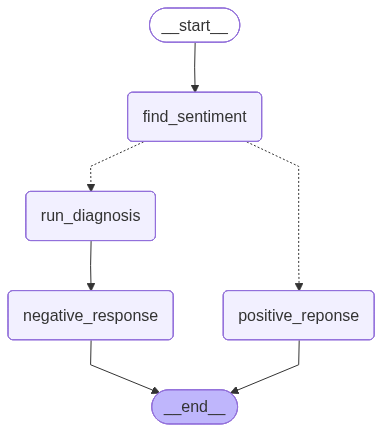

In [107]:
graph = StateGraph(ReviewState)

# Define nodes
graph.add_node('find_sentiment', find_sentiment)
graph.add_node('positive_reponse', positive_response)
graph.add_node('run_diagnosis', run_diagnosis)
graph.add_node("negative_response", negative_response)

# Define edges
graph.add_edge(START, 'find_sentiment')

graph.add_conditional_edges('find_sentiment',check_sentiment)
graph.add_edge('positive_reponse', END)
graph.add_edge('run_diagnosis', 'negative_response')
graph.add_edge('negative_response', END)


workflow = graph.compile()
workflow

In [109]:
initial_state = {
    "customer_message": "I am extremely disappointed with the product I received. It was damaged and did not meet my expectations.",
 }
result = workflow.invoke(initial_state)
result


C:\Users\HP\AppData\Local\Temp\ipykernel_4172\4073788490.py:27: PydanticDeprecatedSince20: The `dict` method is deprecated; use `model_dump` instead. Deprecated in Pydantic V2.0 to be removed in V3.0. See Pydantic V2 Migration Guide at https://errors.pydantic.dev/2.12/migration/
  state.diagnosis = diagnosis.dict()


{'customer_message': 'I am extremely disappointed with the product I received. It was damaged and did not meet my expectations.',
 'sentiment': 'negative',
 'diagnosis': {'issue_type': 'Other', 'urgency': 'High', 'tone': 'angry'},
 'response': "Certainly! Here’s a polite and empathetic response to address the customer’s concerns while acknowledging their frustration:  \n\n---  \n\n**Subject:** We’re Sorry to Hear About Your Experience  \n\nDear [Customer's Name],  \n\nThank you for reaching out to us, and please accept our sincerest apologies for the disappointment you’ve experienced with your order. We understand how frustrating it must be to receive a damaged product that didn’t meet your expectations, and we truly appreciate you bringing this to our attention.  \n\nYour satisfaction is our top priority, and we’d like to make this right for you as quickly as possible. Could you please share a photo of the damaged product or provide a few more details about the issue? This will help u